# Columbus crime markov random field
The dataset consists of a dataframe of per district crime data in a dataframe, along with polygons shapes of the districts. The dataframe contains

- **home.value**: housing value in 1000USD.
- **area**: land area of district
- **income**: household income in 1000USD.
- **crime:** residential burglaries and auto thefts per 1000 households.
- **open.space**: measure of open space in district.
- **district**: code identifying district, and matching names(columb.polys).


We will use this to illustrate use of [`MarkovRandomField`][pymgcv.basis_functions.MarkovRandomField] smoothers. For this dataset, each district has a single observation, but that doesn't have to be the case.

In [1]:
from pymgcv.utils import get_data
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon 
from matplotlib.collections import PatchCollection
import numpy as np
from pymgcv.gam import GAM
from pymgcv.basis_functions import MarkovRandomField
from pymgcv.terms import S

import pymgcv.plot as gplt
data: pd.DataFrame = get_data("columb")
data["district"] = data["district"].astype("string").astype("category")
data.columns = [c.replace(".", "_") for c in data.columns]

names, polys = get_data("columb.polys")
polys = {
    level.item(): poly[np.isnan(poly).any(axis=1)==False]
    for level, poly in zip(names, polys, strict=True)
    }
print(f"N districts: {len(polys)}")
data.head()

N districts: 49


,area,home_value,income,crime,open_space,district,x,y
0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


We can fit a gam with some smooth terms, including the [`MarkovRandomField`][pymgcv.basis_functions.MarkovRandomField]

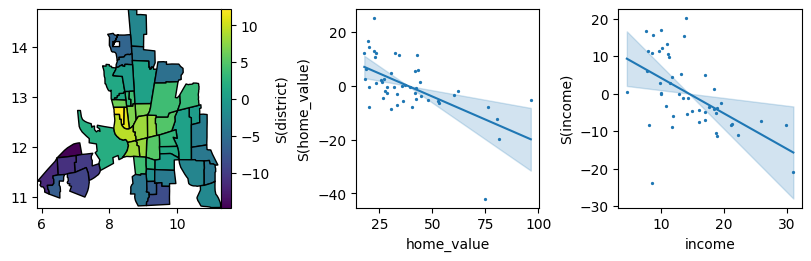

In [2]:
gam = GAM({
    "crime": S("district", bs=MarkovRandomField(polys=polys), k=15) + S("home_value") + S("income")
})
gam.fit(data)
fig, axes = gplt.plot(gam, scatter=True, ncols=3)
fig.set_size_inches(8, 2.5)

Finally, let's plot the predictions against the data, and add a QQ plot

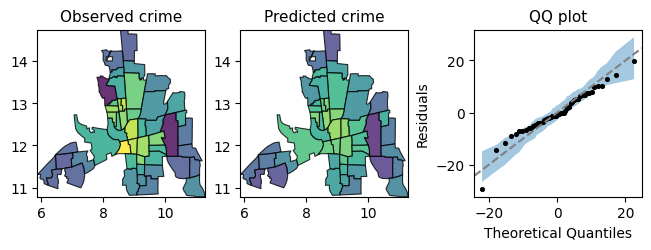

In [3]:
def plot_polys(polys, values, *, ax, clims):
    patches = []
    for poly in polys.values():
        patches.append(Polygon(poly))

    p = PatchCollection(patches, edgecolor='k', linewidth=0.8)
    p.set_array(values)
    p.set_alpha(0.8)
    p.set_clim(vmin=clims[0], vmax=clims[1])
    ax.add_collection(p)

    all_xy = np.vstack([poly for poly in polys.values()])
    ax.set_xlim(all_xy[:,0].min(), all_xy[:,0].max())
    ax.set_ylim(all_xy[:,1].min(), all_xy[:,1].max())
    return ax

fig, axes = plt.subplots(ncols=3, constrained_layout=True)
# share color limits for comparing
predictions = gam.predict()["crime"]
cmin = min(data["crime"].min(), predictions.min())
cmax = max(data["crime"].max(), predictions.max())
plot_polys(polys, data["crime"], ax=axes[0], clims=(cmin, cmax))
plot_polys(polys, gam.predict()["crime"], ax=axes[1], clims=(cmin, cmax))
gplt.qq(gam, ax=axes[2])

titles = ["Observed crime", "Predicted crime", "QQ plot"]
for ax, title in zip(axes, titles, strict=True):
    ax.set_title(title, fontsize=11)
    ax.set_box_aspect(1)
